In [2]:
from pathlib import Path
import sys

project_root = Path.cwd()
while project_root != project_root.parent and not (project_root / "code_lib").exists():
    project_root = project_root.parent

if not (project_root / "code_lib").exists():
    raise RuntimeError(f"Unable to locate 'code_lib' starting from {Path.cwd()}")

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Using project root: {project_root}")


Using project root: c:\Users\luket\Documents\Fork\graph_ml


In [3]:
from pathlib import Path
import sys

import os, glob, re
import pandas as pd
import numpy as np

from pathlib import Path
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


from tqdm import tqdm
from pathlib import Path
from torch_geometric.data import Data
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn.models.tgn import LastNeighborLoader

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder, load_elliptic_data
)
from code_lib.temporal_edge_builder import TemporalEdgeBuilder



In [ ]:
from pathlib import Path

# 1. Locate project root so Python can find code_lib
project_root = Path.cwd()
while project_root != project_root.parent and not (project_root / "code_lib").exists():
    project_root = project_root.parent
if not (project_root / "code_lib").exists():
    raise RuntimeError(f"Unable to locate 'code_lib' starting from {Path.cwd()}")
import sys
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# 2. Imports from our library
from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
)
from code_lib.temporal_edge_builder import TemporalEdgeBuilder

# 3. Load data and instantiate builders
DATA_DIR = project_root / "elliptic_dataset"
nodes_df, raw_edges = load_elliptic_data(str(DATA_DIR), use_temporal_features=True)

edge_builder = TemporalEdgeBuilder(raw_edges, decay_lambda=0.1, verbose=False)
temporal_edges = edge_builder.build_optimized_temporal_edges(
    target_timestep=int(nodes_df["Time step"].max())
)

builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=temporal_edges,
    include_class_as_feature=False,
    add_temporal_features=True,
    add_edge_weights=True,
    edge_weight_col="temporal_weight",
    verbose=False,
)

# 4. Build per-timestep snapshots (non-cumulative) and an event stream
snapshots = builder.build_snapshot_sequence(return_node_metadata=True)



AttributeError: 'GlobalStorage' object has no attribute 'event_type'

In [ ]:
event_stream = builder.build_event_stream(dense=False, include_edge_attr=False)

print(f"Snapshots built: {len(snapshots)} graphs")
print(f"Event stream edges: {event_stream.src.numel()}")

# 5. Temporal train/val/test split on the event stream
splits = builder.get_event_stream_split(
    train_timesteps=(1, 30),
    val_timesteps=(31, 40),
    test_timesteps=(41, 49),
    dense=False,
    include_edge_attr=False,
)

for name, data in splits.items():
    print(
        f"{name.capitalize():5s} -> events: {data.t.numel():7d}, "
        f"t-range: [{data.t.min().item() if data.t.numel() else 'NA'}, "
        f"{data.t.max().item() if data.t.numel() else 'NA'}]"
    )

In [19]:
graphs[0]

Data(x=[34853, 1], edge_index=[2, 66836], y=[34853], node_class=[34853], num_nodes=34853, time_step=1)

In [5]:
from code_lib.temporal_graph_builder import convert_to_event_stream
dataset = convert_to_event_stream(graphs, True)

In [6]:
print(dataset)

TemporalData(src=[2557831], dst=[2557831], t=[2557831], msg=[2557831, 2], y=[2557831], event_type=[2557831])


In [30]:
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator
from torch_geometric.data import TemporalData
num_nodes = nodes['address'].nunique()
raw_msg_dim = (dataset[0].msg.size(-1))
memory_dim = 3
time_dim = 8
print(num_nodes)
print(raw_msg_dim)

822942
2


In [73]:
import torch
import torch.nn as nn
from torch_geometric.nn.models.tgn import TGNMemory, MeanAggregator

class MLPMessage(nn.Module):
    def __init__(self, raw_msg_dim, memory_dim, time_dim,
                 hidden_dim=128, out_dim=128):
        super().__init__()
        in_dim = raw_msg_dim + 2 * memory_dim + time_dim
        self.out_channels = out_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, z_src, z_dst, raw_msg, t_enc):
        inputs = torch.cat([z_src, z_dst, raw_msg, t_enc], dim=-1)
        return self.net(inputs)


In [74]:
message_module = MLPMessage(raw_msg_dim, memory_dim, time_dim, hidden_dim=8, out_dim=8)
DEVICE = torch.device("cuda:0")

neighbor_loader = LastNeighborLoader(
    num_nodes=num_nodes,
    size=50,            # keep only the latest 50 neighbors per node
    device=DEVICE,
)

model = TGNMemory(
    num_nodes = num_nodes,
    raw_msg_dim = raw_msg_dim,
    memory_dim = memory_dim,
    time_dim = time_dim,
    message_module = message_module,
    aggregator_module= MeanAggregator()
).to(DEVICE)
model.reset_state()

decoder = nn.Sequential(nn.Linear(memory_dim*2, 4), nn.ReLU(), nn.Linear(4,1)).to(DEVICE)
opt = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=1e-3)

t_cut = torch.quantile(dataset.t.float(), 0.8).long()

train_mask = dataset.t < t_cut
test_mask = dataset.t >= t_cut

train_data = TemporalData(
    src=dataset.src[train_mask],
    dst=dataset.dst[train_mask],
    msg=dataset.msg[train_mask],
    t=dataset.t[train_mask],
    y=(dataset.y[train_mask] if hasattr(dataset, "y") else None)
)

test_data = TemporalData(
    src=dataset.src[test_mask],
    dst=dataset.dst[test_mask],
    msg=dataset.msg[test_mask],
    t=dataset.t[test_mask],
    y=(dataset.y[test_mask] if hasattr(dataset, "y") else None)
)

train_loader = TemporalDataLoader(train_data, batch_size=16000, shuffle=False)
test_loader = TemporalDataLoader(test_data, batch_size=16000, shuffle=False)
    

In [75]:
print(memory_dim)
print(time_dim)
print(raw_msg_dim)

3
8
2


In [76]:
running_loss = 0.0
running_correct = 0
running_examples = 0

for t, batch in enumerate(train_loader):
    print(batch)
    batch = batch.to(DEVICE)

    n_id, edge_index, e_id = neighbor_loader(batch.n_id)
    model.update_state(batch.src, batch.dst, batch.t, batch.msg)
    h, _ = model(n_id)

    h_src = h[neighbor_loader._assoc[batch.src]]
    h_dst = h[neighbor_loader._assoc[batch.dst]]
    logits = decoder(torch.cat([h_src, h_dst], dim = -1)).view(-1)

    neighbor_loader.insert(batch.src, batch.dst)

    y = batch.y.float().view(-1)
    loss = F.binary_cross_entropy_with_logits(logits, y)

    running_loss += loss.item() * y.numel()

    preds = (logits.sigmoid() >= 0.5).float()
    running_correct += (preds == y).sum().item()
    running_examples += y.numel()

    if (t + 1) % 20 == 0:   # e.g., every 20 mini-batches
        avg_loss = running_loss / running_examples
        avg_acc = running_correct / running_examples
        print(f"[step {t+1}] loss={avg_loss:.4f}, acc={avg_acc:.4f}")

    opt.zero_grad()
    loss.backward()
    opt.step()
    model.detach()

epoch_loss = running_loss / running_examples
epoch_acc = running_correct / running_examples
print(f"Epoch done: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")

TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[9052])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[14466])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[11844])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[7477])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2673])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[3638])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2696])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2028])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2535])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2227])
TemporalData(src=[16000], dst=[16000], t=[16000], msg=[16000, 2], y=[16000], n_id=[2478])
Temporal

In [77]:
checkpoint = {
    "model_state": model.state_dict(),
    "decoder_state": decoder.state_dict(),
    "optimizer_state": opt.state_dict(),
    "config": {
        "raw_msg_dim": raw_msg_dim,
        "memory_dim": memory_dim,
        "time_dim": time_dim,
        "neighbor_size": neighbor_loader.size,
    },
}

Path("artifacts").mkdir(parents=True, exist_ok=True)
torch.save(checkpoint, "artifacts/tgn_checkpoint_dense.pt")


In [ ]:
from torch_geometric.nn.models.tgn import TGNMemory, IdentityMessage, MeanAggregator
from torch_geometric.nn.models.tgn import LastNeighborLoader

DEVICE = torch.device("cuda:0")
ckpt = torch.load("artifacts/tgn_checkpoint_dense.pt", map_location=DEVICE)

cfg = ckpt["config"]
message_module = MLPMessage(cfg["raw_msg_dim"], cfg["memory_dim"], cfg["time_dim"])

model = TGNMemory(
    num_nodes=num_nodes,
    raw_msg_dim=cfg["raw_msg_dim"],
    memory_dim=cfg["memory_dim"],
    time_dim=cfg["time_dim"],
    message_module=message_module,
    aggregator_module=MeanAggregator(),
).to(DEVICE)
model.reset_state()  # clears buffers on the correct device
model.load_state_dict(ckpt["model_state"])

decoder = nn.Sequential(
    nn.Linear(cfg["memory_dim"] * 2,4),
    nn.ReLU(),
    nn.Linear(4, 1),
).to(DEVICE)
decoder.load_state_dict(ckpt["decoder_state"])

opt = torch.optim.Adam(list(model.parameters()) + list(decoder.parameters()), lr=1e-3)
opt.load_state_dict(ckpt["optimizer_state"])

neighbor_loader = LastNeighborLoader(
    num_nodes=num_nodes,
    size=cfg["neighbor_size"],
    device=DEVICE,
)
neighbor_loader.reset_state()


RuntimeError: Error(s) in loading state_dict for TGNMemory:
	Unexpected key(s) in state_dict: "msg_s_module.net.0.weight", "msg_s_module.net.0.bias", "msg_s_module.net.2.weight", "msg_s_module.net.2.bias", "msg_d_module.net.0.weight", "msg_d_module.net.0.bias", "msg_d_module.net.2.weight", "msg_d_module.net.2.bias". 
	size mismatch for gru.weight_ih: copying a param with shape torch.Size([9, 8]) from checkpoint, the shape in current model is torch.Size([9, 16]).

In [ ]:
from sklearn.metrics import recall_score
model.eval()
y_true, y_score = [], []
src_ids= [] 

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(DEVICE)

        # If you used LastNeighborLoader during training, reuse it here:
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        model.update_state(batch.src, batch.dst, batch.t, batch.msg)
        h, _ = model(n_id)

        h_src = h[neighbor_loader._assoc[batch.src]]
        h_dst = h[neighbor_loader._assoc[batch.dst]]
        logits = decoder(torch.cat([h_src, h_dst], dim=-1)).view(-1)

        src_ids.extend(batch.src.cpu().numpy())


        y_score.append(logits.detach().cpu())
        y_true.append(batch.y.detach().cpu())

y_true = torch.cat(y_true).numpy()
y_score = torch.cat(y_score).sigmoid().numpy()
y_pred = (y_score >= 0.5).astype(int)
recall = recall_score(y_true, y_pred, zero_division=0)
print(f"Recall: {recall:.4f}")


Recall: 0.3373


In [62]:
y_true

array([0., 0., 0., ..., 0., 0., 0.], shape=(523867,), dtype=float32)

In [71]:
import pandas as pd

df = pd.DataFrame({
    "node": src_ids,              # or dst_ids, or both concatenated
    "score": y_score,
    "label": y_true,              # 0/1 edge label
})
node_scores = df.groupby("node")["score"].mean()
only_true = df[df["label"] == 1]
only_false = df[df["label"] == 0]

In [70]:
only_true["score"].mean()

np.float32(0.3485955)

In [72]:
only_false["score"].mean()

np.float32(0.34996197)

In [61]:
node_scores.head()

node
0    0.347162
1    0.360979
2    0.350448
3    0.362521
4    0.357726
Name: score, dtype: float32

Looking at precision recall curve to see what the actual fuck is going on

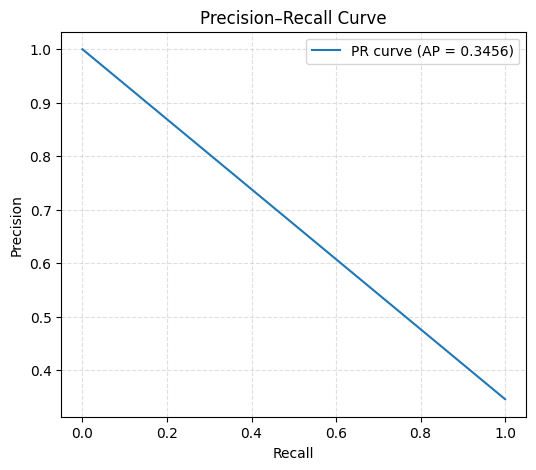

In [46]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_true, y_pred)
ap = average_precision_score(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [47]:
from sklearn.metrics import precision_recall_curve, recall_score

prec, rec, thr = precision_recall_curve(y_true, y_score)  # y_score are probabilities
best = np.argmax(2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1]))  # F1 max
threshold = thr[best]

y_pred = (y_score >= threshold).astype(int)
recall = recall_score(y_true, y_pred, zero_division=0)
print(f"Threshold {threshold:.3f} → recall {recall:.4f}")

Threshold 0.373 → recall 0.0000


C:\Users\luket\AppData\Local\Temp\ipykernel_26088\3494603980.py:4: RuntimeWarning: invalid value encountered in divide
  best = np.argmax(2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1]))  # F1 max


Absolutely diabolical curve, we either have high precision and low recall or low recall and high precision, needs to be fixed by dealing with label imbalance

In [16]:
print("Positives in full set:", int((dataset.y > 0.5).sum()))
print("Negatives in full set:", int((dataset.y <= 0.5).sum()))
print("Positives in test split:", int((test_data.y > 0.5).sum()))
print("Negatives in test split:", int((test_data.y <= 0.5).sum()))

Positives in full set: 409721
Negatives in full set: 2148110
Positives in test split: 181055
Negatives in test split: 342812


It seems the train and test split are not evenly divided, lets try to fix this first

In [ ]:
Before This whole escapade, got quite an improvement by simply setting conversion to dense